In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
num_classes = 10
labels_per_class = 1024 # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline_augmented'
)
print(datestring)

cifar10_1024____2020_08_09_23_20_57_619002_baseline_augmented


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [9]:

lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
input_shape = (32, 32, 3)
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
### conv1a
name = '1a'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
model.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
model.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
model.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
model.add(WeightNormalization(layers.Dense(num_classes, activation=None)))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

### Augmentation

In [11]:
import tensorflow_addons as tfa
def augment(image, label):
    image = tf.squeeze(image) # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, dims[0] + 6, dims[1] + 6) # crop 6 pixels
    image = tf.image.random_crop(image, size=dims)
    image = tf.image.random_brightness(image, max_delta=0.15)  # Random brightness
    image= tf.image.random_contrast(image, lower=0.6, upper=1.4)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.05, seed=None)
    #image = tf.image.random_jpeg_quality(image, 10, 100, seed=None)
    image = tfa.image.rotate(image, tf.squeeze(tf.random.uniform(shape = (1,1), minval=-.2, maxval=.2)), interpolation='BILINEAR')
    image = tfa.image.random_cutout(tf.expand_dims(image, 0), (8,8), constant_values=0.5)[0]
    image = tf.clip_by_value(image, 0, 1)
    return image, label

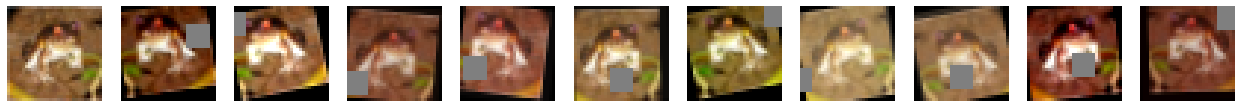

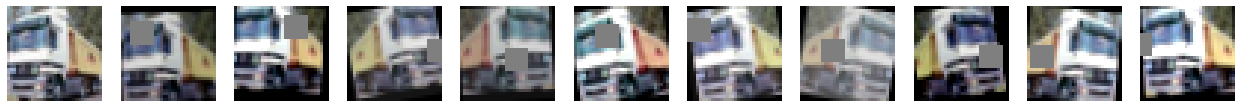

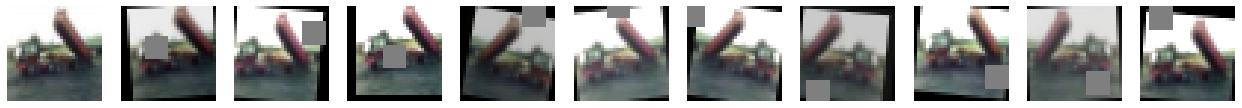

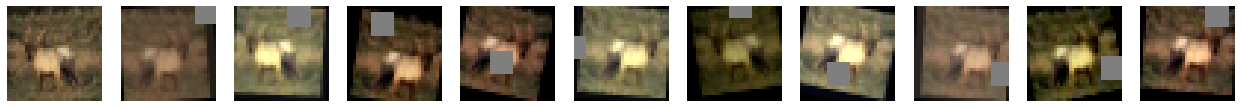

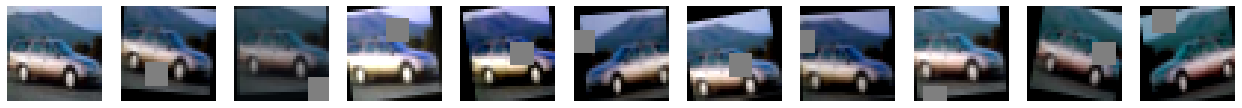

In [12]:
nex = 10
for i in range(5):
    fig, axs = plt.subplots(ncols=nex +1, figsize=((nex+1)*2, 2))
    axs[0].imshow(X_train[i])
    axs[0].axis('off')
    for ax in axs.flatten()[1:]:
        ax.imshow(augment(X_train[i], Y_train[i])[0])
        ax.axis('off')

### train

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [14]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(tf.keras.optimizers.Adam(1e-3), loss = loss, metrics=['accuracy'])

In [15]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [16]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [17]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot))
    .shuffle(5000)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

In [18]:
history = model.fit(
    train_ds,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping]
)

Epoch 1/500
80/80 [==============================] - 15s 185ms/step - loss: 2.2945 - accuracy: 0.2642 - val_loss: 30.0574 - val_accuracy: 0.1061
Epoch 2/500
80/80 [==============================] - 11s 134ms/step - loss: 2.0599 - accuracy: 0.3078 - val_loss: 3.0251 - val_accuracy: 0.1550
Epoch 3/500
80/80 [==============================] - 13s 163ms/step - loss: 2.0215 - accuracy: 0.3317 - val_loss: 2.4541 - val_accuracy: 0.2066
Epoch 4/500
80/80 [==============================] - 12s 145ms/step - loss: 1.9796 - accuracy: 0.3570 - val_loss: 2.1495 - val_accuracy: 0.2750
Epoch 5/500
80/80 [==============================] - 13s 157ms/step - loss: 1.9644 - accuracy: 0.3711 - val_loss: 2.5558 - val_accuracy: 0.2333
Epoch 6/500
80/80 [==============================] - 13s 163ms/step - loss: 1.9312 - accuracy: 0.3940 - val_loss: 2.0797 - val_accuracy: 0.3158
Epoch 7/500
80/80 [==============================] - 11s 140ms/step - loss: 1.8890 - accuracy: 0.4197 - val_loss: 2.5621 - val_accuracy

80/80 [==============================] - 13s 157ms/step - loss: 1.3399 - accuracy: 0.7494 - val_loss: 1.4517 - val_accuracy: 0.6966
Epoch 58/500
80/80 [==============================] - 13s 162ms/step - loss: 1.3218 - accuracy: 0.7588 - val_loss: 1.3258 - val_accuracy: 0.7577
Epoch 59/500
80/80 [==============================] - 11s 138ms/step - loss: 1.3137 - accuracy: 0.7598 - val_loss: 1.3605 - val_accuracy: 0.7461
Epoch 60/500
80/80 [==============================] - 13s 164ms/step - loss: 1.3187 - accuracy: 0.7600 - val_loss: 1.3390 - val_accuracy: 0.7573
Epoch 61/500
80/80 [==============================] - 11s 136ms/step - loss: 1.3111 - accuracy: 0.7653 - val_loss: 1.5975 - val_accuracy: 0.6230
Epoch 62/500
80/80 [==============================] - 13s 164ms/step - loss: 1.3147 - accuracy: 0.7605 - val_loss: 1.3363 - val_accuracy: 0.7553
Epoch 63/500
80/80 [==============================] - 12s 153ms/step - loss: 1.3027 - accuracy: 0.7617 - val_loss: 1.2946 - val_accuracy: 0.772

80/80 [==============================] - 11s 137ms/step - loss: 1.1146 - accuracy: 0.8710 - val_loss: 1.2534 - val_accuracy: 0.8008
Epoch 114/500
80/80 [==============================] - 13s 163ms/step - loss: 1.1045 - accuracy: 0.8738 - val_loss: 1.2546 - val_accuracy: 0.8029
Epoch 115/500
80/80 [==============================] - 12s 155ms/step - loss: 1.1038 - accuracy: 0.8765 - val_loss: 1.2128 - val_accuracy: 0.8217
Epoch 116/500
80/80 [==============================] - 12s 147ms/step - loss: 1.1252 - accuracy: 0.8630 - val_loss: 1.2332 - val_accuracy: 0.8098
Epoch 117/500
80/80 [==============================] - 13s 164ms/step - loss: 1.1183 - accuracy: 0.8649 - val_loss: 1.2169 - val_accuracy: 0.8198
Epoch 118/500
80/80 [==============================] - 11s 134ms/step - loss: 1.1092 - accuracy: 0.8724 - val_loss: 1.2322 - val_accuracy: 0.8125
Epoch 119/500
80/80 [==============================] - 13s 161ms/step - loss: 1.1026 - accuracy: 0.8771 - val_loss: 1.2128 - val_accuracy:

80/80 [==============================] - 13s 163ms/step - loss: 1.0171 - accuracy: 0.9189 - val_loss: 1.2003 - val_accuracy: 0.8369
Epoch 170/500
80/80 [==============================] - 11s 136ms/step - loss: 1.0194 - accuracy: 0.9189 - val_loss: 1.2215 - val_accuracy: 0.8243
Epoch 171/500
80/80 [==============================] - 13s 163ms/step - loss: 1.0154 - accuracy: 0.9246 - val_loss: 1.1904 - val_accuracy: 0.8400
Epoch 172/500
80/80 [==============================] - 13s 157ms/step - loss: 1.0124 - accuracy: 0.9228 - val_loss: 1.1958 - val_accuracy: 0.8370
Epoch 173/500
80/80 [==============================] - 11s 144ms/step - loss: 1.0106 - accuracy: 0.9236 - val_loss: 1.2059 - val_accuracy: 0.8350
Epoch 174/500
80/80 [==============================] - 13s 163ms/step - loss: 1.0113 - accuracy: 0.9266 - val_loss: 1.2079 - val_accuracy: 0.8321
Epoch 175/500
80/80 [==============================] - 11s 134ms/step - loss: 1.0021 - accuracy: 0.9293 - val_loss: 1.1984 - val_accuracy:

80/80 [==============================] - 6s 80ms/step - loss: 0.9680 - accuracy: 0.9496 - val_loss: 1.1594 - val_accuracy: 0.8559
Epoch 226/500
80/80 [==============================] - 6s 81ms/step - loss: 0.9684 - accuracy: 0.9458 - val_loss: 1.1876 - val_accuracy: 0.8453
Epoch 227/500
80/80 [==============================] - 6s 80ms/step - loss: 0.9641 - accuracy: 0.9514 - val_loss: 1.1612 - val_accuracy: 0.8567
Epoch 228/500
80/80 [==============================] - 6s 80ms/step - loss: 0.9629 - accuracy: 0.9491 - val_loss: 1.1936 - val_accuracy: 0.8429
Epoch 229/500
80/80 [==============================] - 6s 81ms/step - loss: 0.9608 - accuracy: 0.9525 - val_loss: 1.1716 - val_accuracy: 0.8532
Epoch 230/500
80/80 [==============================] - 6s 81ms/step - loss: 0.9676 - accuracy: 0.9486 - val_loss: 1.2273 - val_accuracy: 0.8288
Epoch 231/500
80/80 [==============================] - 6s 80ms/step - loss: 0.9690 - accuracy: 0.9494 - val_loss: 1.1846 - val_accuracy: 0.8475
Epoch 

Epoch 282/500
80/80 [==============================] - 6s 81ms/step - loss: 0.9434 - accuracy: 0.9610 - val_loss: 1.1930 - val_accuracy: 0.8468
Epoch 283/500
80/80 [==============================] - 6s 80ms/step - loss: 0.9376 - accuracy: 0.9643 - val_loss: 1.1843 - val_accuracy: 0.8519
Epoch 284/500
80/80 [==============================] - 6s 80ms/step - loss: 0.9455 - accuracy: 0.9592 - val_loss: 1.2228 - val_accuracy: 0.8359
Epoch 285/500
80/80 [==============================] - 6s 81ms/step - loss: 0.9431 - accuracy: 0.9615 - val_loss: 1.2024 - val_accuracy: 0.8409
Epoch 286/500
80/80 [==============================] - 6s 80ms/step - loss: 0.9449 - accuracy: 0.9602 - val_loss: 1.1971 - val_accuracy: 0.8418
Epoch 287/500
80/80 [==============================] - 6s 80ms/step - loss: 0.9363 - accuracy: 0.9635 - val_loss: 1.1805 - val_accuracy: 0.8524
Epoch 288/500
80/80 [==============================] - 6s 80ms/step - loss: 0.9331 - accuracy: 0.9675 - val_loss: 1.1657 - val_accuracy:

### evaluate

In [19]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 3s 9ms/step - loss: 1.2030 - accuracy: 0.8425


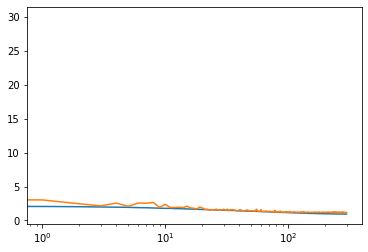

In [20]:
plt.semilogx(history.history['loss'])
plt.semilogx(history.history['val_loss'])

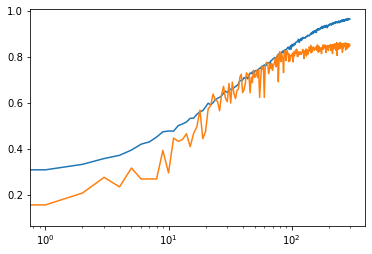

In [21]:
plt.semilogx(history.history['accuracy'])
plt.semilogx(history.history['val_accuracy'])

In [22]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(40000, 256)

In [23]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Mon Aug 10 00:14:04 2020 Finding Nearest Neighbors
Mon Aug 10 00:14:04 2020 Building RP forest with 15 trees
Mon Aug 10 00:14:05 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Mon Aug 10 00:14:14 2020 Finished Nearest Neighbor Search
Mon Aug 10 00:14:17 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Aug 10 00:14:52 2020 Finished embedding


In [24]:
predictions = model.predict(X_train)

In [25]:
mask = np.array(np.argmax(predictions, axis=1)) != Y_train.flatten()

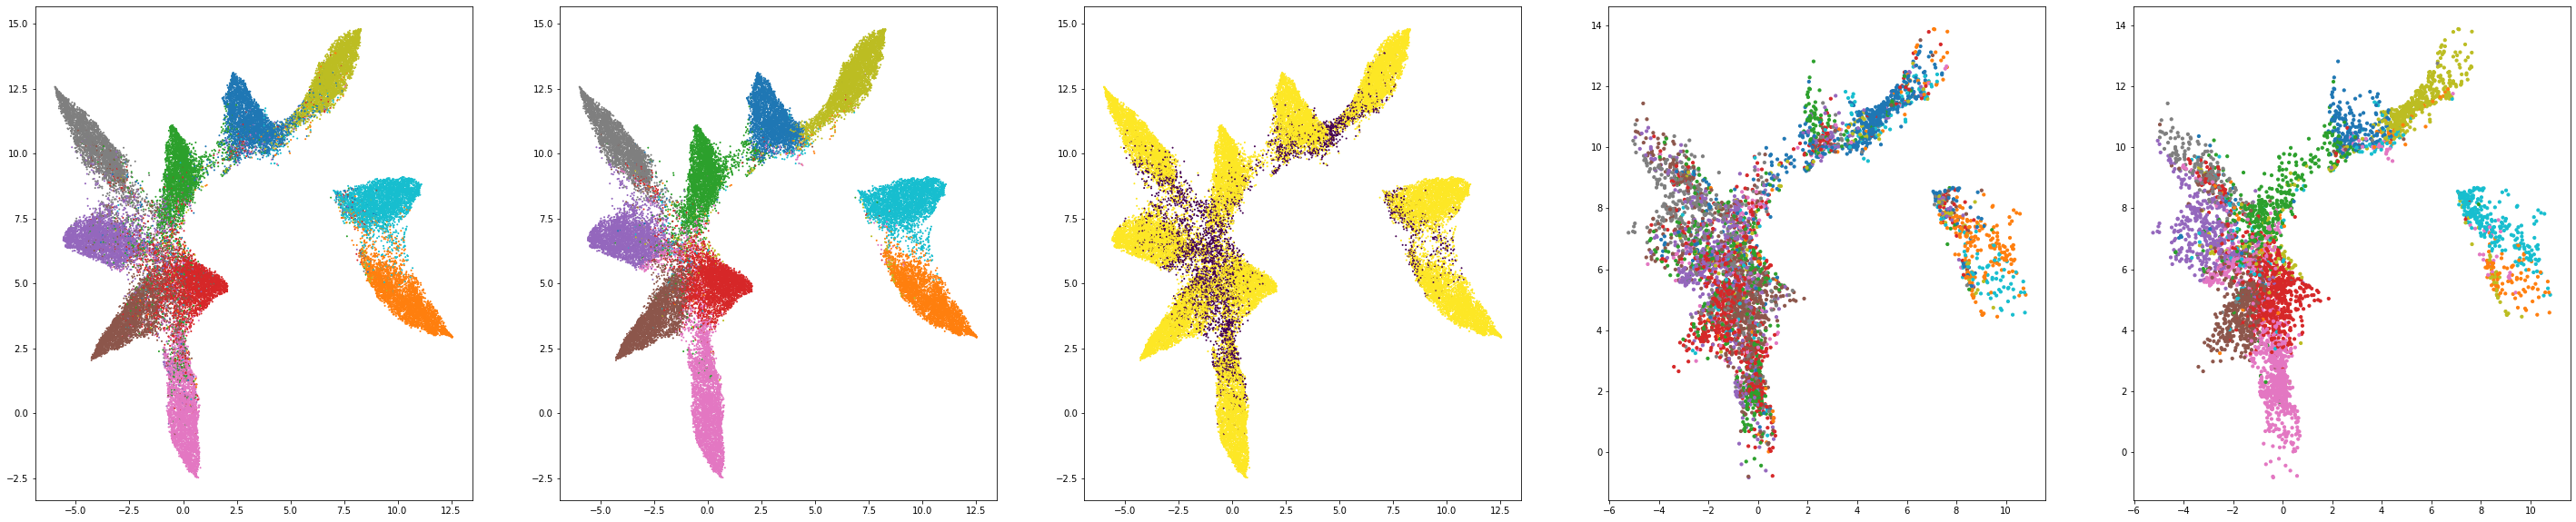

In [26]:
fig, axs = plt.subplots(ncols = 5, figsize=(50,10))
axs[0].scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)
axs[1].scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)
axs[2].scatter(embedding[:, 0], embedding[:, 1], c=np.array(np.argmax(predictions, axis=1)) == Y_train.flatten(), s= 1, alpha = 1, cmap = plt.cm.viridis)
axs[3].scatter(embedding[mask, 0], embedding[mask, 1], c=Y_train.flatten()[mask], s= 10, alpha = 1, cmap = plt.cm.tab10)
axs[4].scatter(embedding[mask, 0], embedding[mask, 1], c=np.argmax(predictions, axis=1)[mask], s= 10, alpha = 1, cmap = plt.cm.tab10)

### save results

In [27]:
# save score, valid embedding, weights, results

In [28]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [29]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [30]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [31]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [32]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

['input_2', 'weight_normalization', 'lrelufc1', 'weight_normalization_1', 'lrelufc2', 'weight_normalization_2']


In [33]:
classifier.save_weights((save_folder / "classifier").as_posix())

In [41]:
model.save_weights((save_folder / "full_model").as_posix())

#### save score

In [34]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 3s 11ms/step - loss: 1.2030 - accuracy: 0.8425


In [35]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [36]:
z = encoder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Mon Aug 10 09:29:50 2020 Finding Nearest Neighbors
Mon Aug 10 09:29:50 2020 Building RP forest with 15 trees
Mon Aug 10 09:29:52 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Mon Aug 10 09:29:54 2020 Finished Nearest Neighbor Search
Mon Aug 10 09:29:55 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Aug 10 09:30:37 2020 Finished embedding


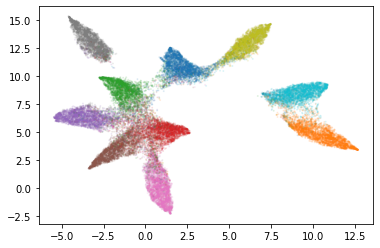

In [37]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [38]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [39]:
import pickle

In [40]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)